# Homework 2 by Lennart Tuijnder


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import time

-----
## Read in the data and pre-process

In [3]:
ListPrefixes = [">chr2L"]

Read in the chromosone by storing it in one string.

Also define the construction of the hashtable, which is returned as a dictionary and is constructed by a sliding window that goes of the chromosone string.

In [2]:
def readGenomeSimple(k):
    with open("data/chr2L.fa","r") as f:
        wholeGenome = f.read()                               
    wholeGenome = wholeGenome.replace("\n","")# Remove the newlines
    for prefix in ListPrefixes: # Remove the prefixes between the chromosones
        wholeGenome = wholeGenome.replace(prefix,"")
    wholeGenome = wholeGenome.upper() # Make everything upper case:
    
    print("Genome processing done!")
    # Create the hashtable:
    hashTable = {}
    for i in range(len(wholeGenome)-k+2):
        try:
            hashTable[wholeGenome[i:i+k]].append(i)
        except:
            hashTable[wholeGenome[i:i+k]] = [i]
    return wholeGenome, hashTable

Construct thme

In [4]:
start = time.time()
wholeGenome, hashTable = readGenomeSimple( k = 8)
end = time.time()
print(end-start)

Genome processing done!
6.507489442825317


Define a function that reads in the "reads". To do this read in every file and then pick out every 4 lines starting from an offset.

Based on the offset we can read in the "read" or the quality of the read. For reverse reads the string is reversed and complimented.

Quality reads are converted from ASCII [64,126] to the numerical input value 0 to 62 represinting the Q_phred score. 

In [5]:
def readReads(fileName, forward = True, Quality=False):
    offset = 1 if not Quality else 3
    with open(fileName,"r") as f:
        lines = f.read().split() # Removes newline char
    reads =  lines[offset::4]
    if not forward:
        for i, reverseRead in enumerate(reads):
            reverseRead = reverseRead[::-1]# Reverse order
            if Quality:
                reads[i] = [ord(char)-64 for char in list(reverseRead)]
            else: # Invert string since the reverse string is read
                reverseRead.replace("A","T")
                reverseRead.replace("T","A")
                reverseRead.replace("C","G")
                reverseRead.replace("G","C")
                reads[i] = reverseRead
    elif Quality:
        for i, read  in enumerate(reads):
            reads[i] = [ord(char)-64 for char in list(read)] # Conver to the Q-score
    return reads

read in the reads:

In [6]:
start = time.time()
readR1 = readReads("data/10000_R1.fastq")
end = time.time()
print(end-start)
start = time.time()
readR2 = readReads("data/10000_R2.fastq", forward=False)
end = time.time()
print(end-start)

0.017784833908081055
0.03165411949157715


Reverse read roughly takes 5x as much time since it needs to be further processed.

Read in the quality

In [7]:
start = time.time()
Quality_R1 = readReads("data/10000_R1.fastq", Quality=True)
end = time.time()
Quality_R2 = readReads("data/10000_R2.fastq", forward=False, Quality=True)
end-start

0.11217164993286133

### Remove garbage entries

To do this flag the reads who have a median quality of lower then 10. Construct a boolian array of the flagged read arrays.

In [377]:
GarbageReads1 = []
for Quality1 in Quality_R1:
    GarbageReads1.append(np.quantile(Quality1,0.50)<10)
GarbageReads2 = []
for Quality2 in Quality_R2:
    GarbageReads2.append(np.quantile(Quality2,0.50)<10)

Doing this removes leaves us stil with 8415 reads. Or 15.85 % is removed.

In [421]:
numberGood = 10000 - np.sum(np.logical_or(GarbageReads1,GarbageReads2))
numberGood

8415

Remove the garbage reads, and construct a smaller data set of with the first 500 reads for testing on the algorithm.

In [379]:
read1Good = np.array(readR1)[~np.logical_or(GarbageReads1,GarbageReads2)]
Quality_R1Good = np.array(Quality_R1)[~np.logical_or(GarbageReads1,GarbageReads2)]
read2Good = np.array(readR2)[~np.logical_or(GarbageReads1,GarbageReads2)]
Quality_R2Good = np.array(Quality_R2)[~np.logical_or(GarbageReads1,GarbageReads2)]

read500Good_1 = read1Good[:500] # First 500 good reads
Q500Good_1 = Quality_R1Good[:500]
read500Good_2 = read2Good[:500] # First 500 good reads
Q500Good_2 = Quality_R2Good[:500]

## The Main algorithm

Next the main algorithm is given. This exist mainly out of two parts. A function that finds the maximum uniterrupted overlap between a read and the genome and overall loop that goes through all the reads and calls the function.

### The function

First, we define a function that will give back the position on the genome where the read has a maximum uniterrupted overlap with the genome. To do this the function is provided a list of the different seeds coming from the same read. 

After creating some variables to save some numbers, the function will loop over each provided seed of that has been given. First a quality check is done to see if the provided seed has high quality and can thus be unsured to be equal to the true read mRNA sequence. 

For each seed, the function will try to find its maximumly uniterrupted section on the genome. To do this we look up all its matches on the genome with the hash table. For each seed we will then extent to either side on the genome and see how far we get without encountering a mistake. Here, a small check is also perfomed to see if the seed considerd on the genome is not on either side of the chromosone since then the extend might go over the edge.  

When looping through all the matches on the genome for each seed of the read the overall maximum extend is saved. This is saved togheter with the its location on the genome and the index on the read where this overlap starts. 

If a second seed on the genome is found with the same amount of overlap as the current maximum. We first need to perform a check if this is clearly a different regions. This could happend if two provided seeds of the read overlap this region, which will then both give back that same region on the genome. However, if the new overlapping region is found to be different then already current maximum, we also store, rather then overwritting. 

In the end the function stores a list of all starting position on the genome of regions who all have the same overlapping lenght on the genome, but at different places. When a new maximum lenght is found, all the previous records are flushed and the new list now again only contains this one entry. 

An additional input entry `after` is given which is used for the mapping of the reverse read. The `after` parameter provided controll over which seeds on the genome should be considerd. Only the matches on the genome behind the position `after` are considerd. By default this is zero, meaning the whole genome is considerd. But this can be used to constraint the search for the reverse read since it is know to lie behind the first read. 

In the end the function returns the following elements:

- maximumExtent: the length of the maximumally constant overlap between the read and the genome:
- numberWithMax: the number of overlaps with lenght `maximumExtent` on the genome.
- genomeStartPosition: Starting position on the genome for each of the `maximumExtent` overlaps. 
- startIndexRead: Corresponding index on the Read itself that should be matched with the `genomeStartPosition` to make the overlap. 

In [426]:
def findMaximumExtend(readSeeds, QReadSeeds, after = 0):
    maximumExtent = 0
    numberWithMax = 0 # unique amount of genome position with the same amount of extend.
    
    refNumbers = [] # Reference number is maybe not equal to the genomePosition number!
    
    genomeStartPosition = []
    startIndexRead = []
    
    for i, (readSeed,QReadSeed) in enumerate(zip(readSeeds,QReadSeeds)):
        #Check quality seed:
        falseSeed = False
        for Q in QReadSeed:
            if Q < 15: # Do not allow seeds that have some where quality score of lower then 15
                falseSeed=True
                break
        if falseSeed:
            continue
        
        seedsOnGenome = hashTable[readSeed]
        seedsOnGenome = [seed for seed in seedsOnGenome if seed >= after] # Seeds to be considerd should be bigger then
        if len(seedsOnGenome) == 0: # Return empty if no seeds are left anymore
            return 0,0,[],[]
        startPos = k*i
        
        for seed in seedsOnGenome:
            if seed>(len(wholeGenome)-76) or seed<76: # Becarefull with edges cases on the chromosone
                continue
            extensionLenght = k
            startIndex = startPos
            startGenome = seed
            # Extend to the right
            for j in range(76-startPos-k):
                if read[startPos+k+j] != wholeGenome[seed + k + j]:
                    break
                extensionLenght += 1
            
            # Extend to the left
            for j in range(-1,-startPos-1,-1):
                if read[startPos+j] != wholeGenome[seed + j]:
                    startIndex += (j+1)
                    startGenome += (j+1)
                    break
                extensionLenght += 1  
            
            if extensionLenght > maximumExtent:
                maximumExtent = extensionLenght
                numberWithMax = 1
                refNumbers = [seed-startPos] # Store the refnumber
                genomeStartPosition = [startGenome]
                startIndexRead = [startIndex]
                
            elif extensionLenght == maximumExtent and (seed-startPos) not in refNumbers:
                refNumbers.append(seed-startPos)
                genomeStartPosition.append(startGenome)
                numberWithMax += 1
                startIndexRead.append(startIndex)
                
    return maximumExtent, numberWithMax, genomeStartPosition, startIndexRead

### Main loop:

In the main loop we go over each forward and reverse read togheter with there quality score. We then first split it into the different seeds 

In [432]:
TimeStart= time.time()

boolianRead1 = []
boolianRead2 = []

MappingR1 = []
MappingR2 = []

for read1, quality1, read2, quality2 in zip(read1Good, Quality_R1Good, read2Good, Quality_R2Good):
    # Split the read in each seed
    readSeeds1 = [read1[i:i+k] for i in range(0, len(read1), k)][:-1] 
    qReadSeeds1 = [quality1[i:i+k] for i in range(0, len(quality1), k)][:-1] 
    
    readSeeds2 = [read2[i:i+k] for i in range(len(read2)%k,len(read2),k)]
    qReadSeeds2 = [quality2[i:i+k] for i in range(len(quality2)%k,len(quality2),k)]
    
    maxExtent1, numWithMax1, genPosition1, IndexRead1 = findMaximumExtend(readSeeds1, qReadSeeds1)
    minPosition = 0 if maxExtent1<14 else min(genPosition1)
    maxExtent2, numWithMax2, genPosition2, IndexRead2 = findMaximumExtend(readSeeds2, qReadSeeds2, minPosition)
    
    # Now impose a threshold on the minimum max lenght needed 
    # Before we are able to tell that this is indeed a hit or not duo random chance
    if maxExtent1<15:
        # Declare that no mapping was found for this read
        maxExtent1 = 0
        genPosition1 = []
        IndexRead1 = []
    if maxExtent1==0 and maxExtent2<15: # if MaxExtent<14 then read2 had the chance to search on the whole genome
        # Declare that no mapping was found for this read
        maxExtent2 = 0
        genPosition2 = []
        IndexRead2 = []
    if maxExtent1!=0 and maxExtent2<14: # When maxExtent1 is valid then be less harsh on maxExtent2 since the search space was now smaller
        maxExtent2 = 0
        genPosition2 = []
        IndexRead2 = []
    
    # Save the mappings:
    MappingR1.append((IndexRead1, genPosition1, maxExtent1))
    MappingR2.append((IndexRead2, genPosition2, maxExtent2))
    
    # Declare with boolian vector if we found a place for R1 or R2:
    if maxExtent1==0:
        boolianRead1.append(False)
    else:
        boolianRead1.append(True)
        
    if maxExtent2==0:
        boolianRead2.append(False)
    else:
        boolianRead2.append(True)
    

TimeStop = time.time()
print(TimeStop-TimeStart)

107.60827231407166


In [433]:
np.sum(boolianRead1)

5017

In [434]:
np.sum(boolianRead1)/numberGood

0.5961972667855021

In [435]:
np.sum(boolianRead2)

4316

In [436]:
np.sum(boolianRead2)/numberGood

0.512893642305407

#####
--------
# Other algorithms

Below here other algorithms were explored. and are not part any more of the assignm

------

So now we have a string of the whole genome so we can quickly acces it -> And we have all the reads -> It is now time to start mapping! 

In [1]:
k = 8

let's for now focus on the first 500 reads:

In [8]:
read500 = readR1[:500]

Current approach for mapping:

Break up the read in smaller seed sections: named seed_i, these seeds are next to each other.

Then the first round of search is tyring to find an exact match for seed_1 and seed_2 that are that are exactly k distant from each other. 

Aka we first go through the reads whose first $2*k$ map exactly! If a match is found -> condsider this as the correct starting position. 

In the first version ignore N's for the moment

In [11]:
num = 0
readStartWithN = []
for i, read in enumerate(readR1):
    if read[0]=="N":
        num+=1
        readStartWithN.append(i)
num, readStartWithN

(34,
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  474,
  1180,
  1720,
  1856,
  1946,
  2622,
  2792,
  3052,
  3460,
  4461,
  4537,
  4659,
  4801,
  7066,
  7152,
  7155,
  7381,
  7694,
  8206,
  8315,
  8969,
  8981])

In [134]:
def mapping(reads):
    mappedReads = []
    for read in reads:
        seed1 = read[0:k]
        seed2 = read[k:2*k]
        seed3 = read[2*k:3*k]
        if seed1=="AAAAAAAA" and seed2 == "AAAAAAAA":
            possibleLoc = [-1]
        else:
            possibleLoc = findExactMatch(seed1, seed2, k)
        if len(possibleLoc)==0:
            possibleLoc = findExactMatch(seed2, seed3, k)
        if len(possibleLoc)==0:
            possibleLoc = findExactMatch(seed1, seed3, 2*k)
        
        mappedReads.append(possibleLoc)
    return mappedReads

In [145]:
def findExactMatch(seed1, seed2, diff):
    try:
        MatchesSeed1 = hashTable[seed1]
        MatchesSeed2 = hashTable[seed2]
    except:
        return []
    N1 = len(MatchesSeed1)
    N2 = len(MatchesSeed2)
    index1 = 0
    index2 = 0
    listLoc = []
    try:
        for i in range(N1+N2): # Maximum search space is N1+N2
            if (MatchesSeed2[index2] - MatchesSeed1[index1]) < diff: # Only positif diff is supported!
                index2 += 1
                if index2>=N2: # We ran out of r2 seeds
                    break
            elif (MatchesSeed2[index2] - MatchesSeed1[index1]) > diff:
                index1 +=1
                if index1>=N1:
                    break
            else:
                listLoc.append(MatchesSeed1[index1])
                index1 += 1
                index2 += 1
                if index2>=N2 or index1>=N1: # We ran out of r2 seeds
                    break
    except:
        print("Error:")
        print(f"N1={N1}, N2={N2}")
        print(f"index1={index1}, index2={index2}")
    return listLoc

In [146]:
mapping10000 = mapping(readR1)

In [153]:
lengthMap = []
count=0
for l in mapping10000:
    if len(l)!=0 and l!=[-1]:
        count+=1
        lengthMap.append(len(l))
count

1256

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 1097.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,   53.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    9.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,   14.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    6.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
        3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 <a list of 50 Patch objects>)

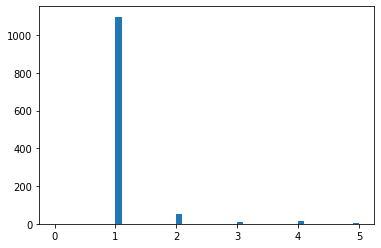

In [157]:
plt.hist(lengthMap,50,(0,5))

With this appraoch roughly 10 % can be found! -> This does not reduces it enough to now try a more expensive one. 

But can be done really quick ! So maybe we can try to do it less hard!

With this approach -> 

In [198]:

readMapping = []

invalidM1 = 0
above1000 = 0
listMaxExtend = []

for read in read500:
    try:
        matches1 = hashTable[read[0:k]]
    except:
        invalidM1 +=1
        continue
#     if len(matches1)>1000:
#         above1000 +=1
#         continue
    # -------
    # Seed and extend
    extend = []
    for seed in matches1:
        for i in range(k+1,75):
            if read[:i]!=wholeGenome[seed:seed+i]:
                extend.append(i) 
                break
    listMaxExtend.append(extend)

In [212]:
maxExtend = []
numberOfMaxExtend = []
for l in listMaxExtend:
    l = np.array(l)
    maxExtend.append(max(l))
    numberOfMaxExtend.append(np.sum(l==max(l)))

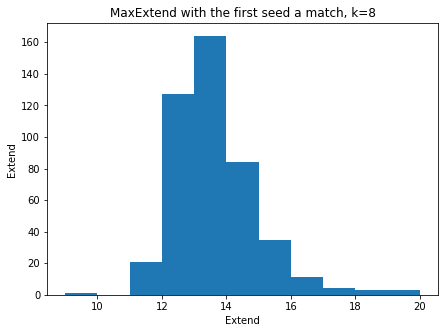

In [209]:
fig = plt.figure(figsize=(7,5))
plt.hist(maxExtend,11,(k+1,20))
plt.title("MaxExtend with the first seed a match, k=8")
plt.xlabel("Extend")
plt.ylabel("Extend")
fig.savefig("MaxExtendk8")

(array([  0., 253.,  90.,  57.,  29.,  19.,   5.,   8.,   6.,   3.,   3.,
          4.,   1.,   1.,   2.,   0.,   1.,   0.,   0.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <a list of 20 Patch objects>)

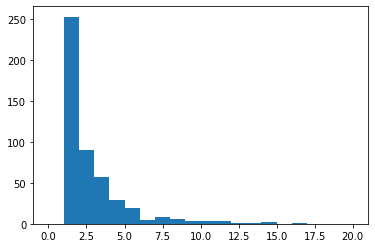

In [216]:
plt.hist(numberOfMaxExtend,20,(0,20))

------

Let's now allow some extension with errors

Evaluate different amounts of errors.  1,2,3 (and so how much we can further extend)

In [235]:
testL1 = "ACTAG"
testL2 = "CCTAG"

In [279]:
readMapping = []

invalidM1 = 0
above1000 = 0
listWithNoError = []
listWithOneError = []
listWithTwoError = []
listReachedEnd = []

for read in read500:
    try:
        matches1 = hashTable[read[0:k]]
    except:
        invalidM1 +=1
        continue
#     if len(matches1)>1000:
#         above1000 +=1
#         continue
    # -------
    # Seed and extend
    
    extWithNoError = []
    extWithOneError = []
    extWithTwoError = []
    
    ReachedEnd = []
    
    for seed in matches1:
        Errors = 0
        for i in range(k,75):
            if read[i]!=wholeGenome[seed+i]:
                Errors += 1
                if Errors == 1:
                    extWithNoError.append(i)
                elif Errors ==2:
                    extWithOneError.append(i)
                elif Errors==3:
                    extWithTwoError.append(i)
                    break
        ReachedEnd.append(Errors)
            
    #indexMax = np.where(extend == np.amax(extend))[0]
    
    listWithNoError.append(extWithNoError)
    listWithOneError.append(extWithOneError)
    listWithTwoError.append(extWithTwoError)
    listReachedEnd.append(ReachedEnd)

In [252]:
testList = [0,5,4,3,7,8]
np.where(testList == np.amax(testList))[0]

array([5])

In [272]:
np.arange(10)[8:]

array([8, 9])

In [280]:
maxExtendNoError = []
numExtendNoError = []
for l in listWithNoError:
    l = np.array(l)
    maxExtendNoError.append(max(l))
    numExtendNoError.append(np.sum(l==max(l)))
    
maxExtendOneError = []
numExtendOneError = []
for l in listWithOneError:
    l = np.array(l)
    maxExtendOneError.append(max(l))
    numExtendOneError.append(np.sum(l==max(l)))
    
maxExtendTwoError = []
numExtendTwoError = []
for l in listWithTwoError:
    l = np.array(l)
    maxExtendTwoError.append(max(l))
    numExtendTwoError.append(np.sum(l==max(l)))
    
maxReachedEnd = []
numReachedEnd = []
for l in listReachedEnd:
    l = np.array(l)
    maxReachedEnd.append(max(l))
    numReachedEnd.append(np.sum(l==max(l)))

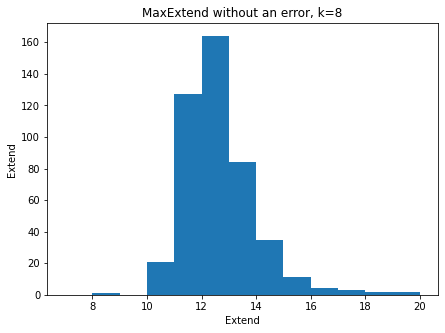

In [285]:
fig = plt.figure(figsize=(7,5))
plt.hist(maxExtendNoError,13,range=(7,20))
plt.title("MaxExtend without an error, k=8")
plt.xlabel("Extend")
plt.ylabel("Extend")
fig.savefig("MaxExtendk8")

-> From this we conclude that, actually in most cases you can only extend up to 12 basis without making a mistake!

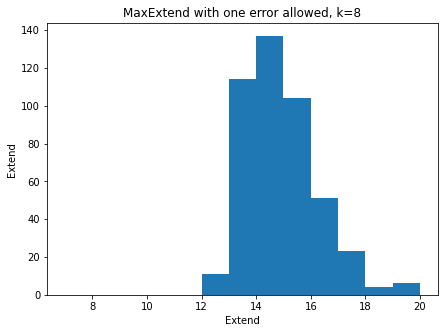

In [290]:
fig = plt.figure(figsize=(7,5))
plt.hist(maxExtendOneError,13,range=(7,20))
plt.title("MaxExtend with one error allowed, k=8")
plt.xlabel("Extend")
plt.ylabel("Extend")
fig.savefig("MaxExtendk8")

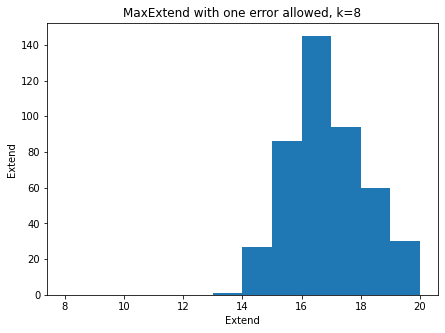

In [297]:
fig = plt.figure(figsize=(7,5))
plt.hist(maxExtendTwoError,12,range=(8,20))
plt.title("MaxExtend with one error allowed, k=8")
plt.xlabel("Extend")
plt.ylabel("Extend")
fig.savefig("MaxExtendk8")

-> The number at 75 does increase significantly if we allow a bit more errors. 

---------

Map with score:

In [369]:
Q500 = Quality_R1[:500]

In [327]:
ListScores = []
for read, Quality in zip(read500, Q500):
    try:
        matches1 = hashTable[read[0:k]]
    except:
        invalidM1 +=1
        continue
    if len(matches1)>1000:
        above1000 +=1
        continue
    # -------
    # Seed and extend
    
    
    ScoreRead = []
    for seed in matches1:
        score = [0]
        for i in range(k,75):
            if read[i]!=wholeGenome[seed+i]:
                score.append(Quality[i])
        ScoreRead.append(score)
    ListScores.append(ScoreRead)

In [378]:
for i, readQ in enumerate(Q500):
    for j, q in enumerate(readQ):
        if q>40:
            print(i,j)
            print(f"q={q}")

-> All the scores seem to be really high ! There is no value below 33. While and all the rest is always in the range 50->60 I think the scale is here different. Because when we get a "D" which should be aqualtiy of 33 -> 0.999% it is would be guessed wrong -> is unknow. Hence, I think the zero value is "A" instead thus 65 instead of 33-> This would explain non reads with score D and the "AAAAAAAAAAA" who have score B. 

Wiki page: https://en.wikipedia.org/wiki/FASTQ_format encoding! All Q scores of 2 or lower are set to 2 -> Aka B! B= baddes score!

-> The wiki confirms the scoring starts from asci 64 to 126!

In [362]:
plt.plot(ListScores[0][0])

[0,
 64,
 65,
 65,
 65,
 65,
 65,
 64,
 64,
 65,
 63,
 64,
 64,
 58,
 64,
 64,
 63,
 61,
 64,
 62,
 63,
 64,
 54,
 53,
 61,
 63,
 56,
 61,
 60,
 60,
 60,
 60,
 62,
 62,
 54,
 53,
 56,
 59,
 56,
 59,
 57,
 50,
 59,
 48,
 58,
 50,
 60,
 58,
 44,
 53,
 53]

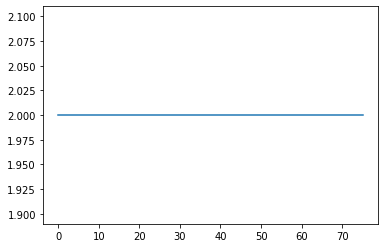

In [384]:
plt.plot(Quality_R1[90])

-----------------------------------

# Seed and expand

In [10]:
read500 = readR1[:500]
Q500 = Quality_R1[:500]
k = 8

Define what is garbage:

In [69]:
GarbageReads = []
Garbage = 0 
for Quality in Quality_R1:
    IsGarbage = np.quantile(Quality,0.50)<10
    if IsGarbage:
        Garbage+=1
    GarbageReads.append(IsGarbage)

Remove garbage Reads:

In [80]:
read1Good = np.array(readR1)[~np.array(GarbageReads)]
Quality_R1Good = np.array(Quality_R1)[~np.array(GarbageReads)]
read500Good = read1Good[:500] # First 500 good reads
Q500Good = Quality_R1Good[:500]

In [175]:
TimeStart= time.time()

RangeGoodStart = 20 #Range of quality check for starting seed
ScoreThreshold = 100
WeedingOutRegion = 14 # After how much extra reads should we consider by weeding out. 

listWhereGetsOut = []
listCandidateSeeds = []

for read, Quality in zip(read500Good, Q500Good):
    ### Find Good Starting Seed:
    start = 0
    foundStartSeed = False
    for i in range(RangeGoodStart): 
        if Quality[i] < 10: # Condsider an extremely read seed a score below 10
            start = i+1 #Then the next best possible start could only be i+1
        if i-start == (k-1):
            foundStartSeed = True
            break
    if not foundStartSeed:
        continue # Go to the next read
        
    ### Seed and expand
    SeedRead = read[start:start+k]
    seeds = hashTable[SeedRead]
    
    candidateSeeds = []
    whereGetsOut = []
    for seed in seeds:
        score = 0 # Keep track of score.
        # Expand to the right (99% has start 0 or 1 -> So go to the right)
        falseSeed = False
        for i in range(start+k , start+k+WeedingOutRegion): # Start from k since we now that 
            if read[i]!=wholeGenome[seed+i]: # If mistake occurs add it to the score
                score += Quality[i]
            if score > ScoreThreshold:
                falseSeed = True
                whereGetsOut.append(i-start-k) # Return itteration at where they left out
                break
        if not falseSeed:
            candidateSeeds.append(seed)
            
    listWhereGetsOut.append(whereGetsOut)
    listCandidateSeeds.append(candidateSeeds)
    
#     if len(candidateSeeds) > 50:
#         print(f"len(candidateSeeds)= {len(candidateSeeds)}")
#         print(read)
#         print(Quality)
    
    

TimeStop = time.time()
print(TimeStop-TimeStart)

0.7579610347747803


#### Discussion on scoring and stuff:

With score: 50 and test in the next 10: -> 453 do not make it! (only 35 with just one / 5 with two and 2) We see those with many matches have either all A's or but with high quality read. Or very repatative sequence. -> I do belivie that these reads can be correct. However there is no way to match them correctly for us! So hence we will not consider them in the mapping!

So after whatching in detail some allignment indeed seems to work like how I want -> But there are just many reads that thus seem to stop early.


----
Lowering the number the region in which you look (to 6), Seems to help, howver still a consider amount is in the 0 and many are there now really seems to be a distribution from 0 to 15 -> Most of these or probably false positives. Let's be a bit kinder with the score.

Keeping it at extended range 10: But now having a higher score: 70 (should allow two high permutations) -> Highering the score does not really seem to help. That much only 87 are with one and many other with many more:

Having a extended region 6 with 70: -> Way to many values positives! 


(array([449.,  37.,   7.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <a list of 20 Patch objects>)

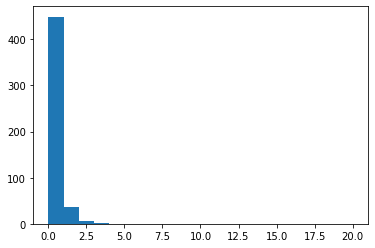

In [176]:
numberCandidates= []
for candidates in listCandidateSeeds:
    numberCandidates.append(len(candidates))
np.array(numberCandidates)[np.array(numberCandidates)>3]
plt.hist(numberCandidates,20,(0,20))

(array([  0., 116.,  31.,  13.,   1.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

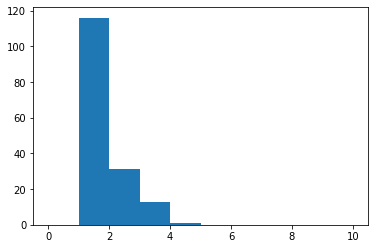

In [164]:
read = 17
plt.hist(listWhereGetsOut[read], 10,(0,10))

Print for a given read the genome that had a high and evaluate if the seed was good or not:

In [160]:
read = 17
seedRead = read500Good[read][0:8] # Assume no start
matches =  hashTable[seedRead]
indexGoodSeed = np.where(np.array(listWhereGetsOut[read])==4)
# Seed 
for index in indexGoodSeed[0]:
    print(index)
    goodSeedGenomPos = matches[index]
    print("-------------------")
    print(wholeGenome[goodSeedGenomPos:goodSeedGenomPos+76])
    print(read500Good[read])
    print(Quality_R1Good[read])

127
-------------------
GACTTAGAGGAATTTCAGAAGGTCTATAATTGCGTCAACAAGTCGTTGTTTTGTGTTTTGATCCAACCCCGGATAG
GACTTAGAGGCACTCGACTTGGACCAAAGTTTGCATTGGATAGGTCATTCATATGCGCGGGTGGACAGCGTGGCAT
[33 33 34 33 33 33 29 30 32 33 34 34 33 33 33 32 33 33 33 33 33 32 33 33
 33 31 23 31 32 27 32 33 33 34 33 33 33 33 33 27 32 30 29 33 27 33 32 33
 33 32 29 31 29 30 32 32 32 33 31 30 28 15 28 32 26 24 16 28 29 30 13 26
 29 28 22 32]


#### Discussion on Garbage and good start:

By removing garbage read we have drastically improven the quality and we are now able to always find a good start condition! (for the whole 10000 data set!)

From the 10000 Reads:

- 9479 non garbage 94.79% ( I know that 80% is low quality first quantile <10)
- 9400 Have a good first start = 99.16 %
- 32 Have a good start at 1.
- Of those starting with >2 -> The median quality is above 20 So definitly workable!

In [263]:
TimeStart= time.time()

ScoreThreshold = 40

ListCandidateRight = []
ListCandidateLeft = []

for readNum, (read, Quality) in enumerate(zip(read500Good, Q500Good)):
    # Split the read in each seed
    readSeeds = [read[i:i+k] for i in range(0, len(read), k)][:-1] 
    QReadSeeds = [Quality[i:i+k] for i in range(0, len(Quality), k)][:-1] 
    
    possibleCandidatesRight = []
    possibleCandidatesLeft = []
    
    for i, (readSeed,QReadSeed) in enumerate(zip(readSeeds,QReadSeeds)):
        # Check seed quality
        falseSeed = False
        for Q in QReadSeed:
            if Q < 15: # Do not allow seeds that have some where quality score of lower then 15
                falseSeed=True
                break
        if falseSeed:
            continue
        
        # Search for possible positions on the genome via the seed and extend on both the left and right side
        startPos =  k*i
        seedsGenome = hashTable[SeedRead]
        
        rightCandidateSeeds = []
        leftCandidateSeeds = []
        
        for seed in seedsGenome:
            ##Right
            if (startPos+k+k)<75:
                RightScore = 0
                ReachedRightThreshold = False
                for j in range(k,k+k):
                    if read[startPos+j] != wholeGenome[seed+j]:
                        RightScore += Quality[startPos+j]
                        if RightScore>ScoreThreshold:
                            ReachedRightThreshold = True 
                            break
                if not ReachedRightThreshold:
                    rightCandidateSeeds.append(seed-startPos) # Normalise to the start of the readPos.
            
            ##Left 
            if (startPos-k)<0:
                LeftScore = 0
                ReachedLeftThreshold = False
                for j in range(0,-k,-1):
                    if read[startPos+j] != wholeGenome[seed+j]:
                        LeftScore += Quality[startPos+j]
                        if LeftScore>ScoreThreshold:
                            ReachedLeftThreshold = True 
                            break    
                if not ReachedLeftThreshold:
                    leftCandidateSeeds.append(seed-startPos) # Normalise to the start of the readPos.
                
        possibleCandidatesRight.append(rightCandidateSeeds)
        possibleCandidatesLeft.append(leftCandidateSeeds)
    
    ListCandidateRight.append(possibleCandidatesRight)
    ListCandidateLeft.append(possibleCandidatesLeft)

TimeStop = time.time()
print(TimeStop-TimeStart)

2.086927890777588


In [231]:
read = 14
print(Q500Good[read])

[33 32 32 33 30 33 32 32 32 32 32 32 30 33 32 33 32 32 32 30 33 32 30 33
 28 28 32 33 32 32 32 32 32 29 24 30 29 29 28 29 31 32 33 32 32 30 30 33
 28 28 30 28 30 32 29 28 28 32 20 32 25 28 28 19 25 29 24 18 28 25 25 28
 24 18 18 22]


--------------------------------------------

The approach with the score does not seem to be working...

We now try with exact matching. -> For each read divide it into sub reads and try to maximumly extend! Define a lenght of which we can then say this could not have happend with chance. 

In [268]:
for N in range(20):
    print(N, len(wholeGenome)/pow(4,N))

0 23513712.0
1 5878428.0
2 1469607.0
3 367401.75
4 91850.4375
5 22962.609375
6 5740.65234375
7 1435.1630859375
8 358.790771484375
9 89.69769287109375
10 22.424423217773438
11 5.606105804443359
12 1.4015264511108398
13 0.35038161277770996
14 0.08759540319442749
15 0.021898850798606873
16 0.005474712699651718
17 0.0013686781749129295
18 0.0003421695437282324
19 8.55423859320581e-05


In [377]:
GarbageReads1 = []
for Quality1 in Quality_R1:
    GarbageReads1.append(np.quantile(Quality1,0.50)<10)
GarbageReads2 = []
for Quality2 in Quality_R2:
    GarbageReads2.append(np.quantile(Quality2,0.50)<10)

In [421]:
numberGood = 10000 - np.sum(np.logical_or(GarbageReads1,GarbageReads2))
numberGood

8415

In [379]:
read1Good = np.array(readR1)[~np.logical_or(GarbageReads1,GarbageReads2)]
Quality_R1Good = np.array(Quality_R1)[~np.logical_or(GarbageReads1,GarbageReads2)]
read2Good = np.array(readR2)[~np.logical_or(GarbageReads1,GarbageReads2)]
Quality_R2Good = np.array(Quality_R2)[~np.logical_or(GarbageReads1,GarbageReads2)]

read500Good_1 = read1Good[:500] # First 500 good reads
Q500Good_1 = Quality_R1Good[:500]
read500Good_2 = read2Good[:500] # First 500 good reads
Q500Good_2 = Quality_R2Good[:500]

In [354]:
[test[i:i+k] for i in range(len(test)%k,len(test),k)]

['TTGAGTAT',
 'ACTGTACC',
 'TTCTGCCT',
 'CGATGTAA',
 'GGACAAGT',
 'GAAGGCTC',
 'AGGCAACC',
 'GCTCCCAG',
 'TAGGTCTG']

In [432]:
TimeStart= time.time()

boolianRead1 = []
boolianRead2 = []

MappingR1 = []
MappingR2 = []

for read1, quality1, read2, quality2 in zip(read1Good, Quality_R1Good, read2Good, Quality_R2Good):
    # Split the read in each seed
    readSeeds1 = [read1[i:i+k] for i in range(0, len(read1), k)][:-1] 
    qReadSeeds1 = [quality1[i:i+k] for i in range(0, len(quality1), k)][:-1] 
    
    readSeeds2 = [read2[i:i+k] for i in range(len(read2)%k,len(read2),k)]
    qReadSeeds2 = [quality2[i:i+k] for i in range(len(quality2)%k,len(quality2),k)]
    
    maxExtent1, numWithMax1, genPosition1, IndexRead1 = findMaximumExtend(readSeeds1, qReadSeeds1)
    minPosition = 0 if maxExtent1<14 else min(genPosition1)
    maxExtent2, numWithMax2, genPosition2, IndexRead2 = findMaximumExtend(readSeeds2, qReadSeeds2, minPosition)
    
    # Now impose a threshold on the minimum max lenght needed 
    # Before we are able to tell that this is indeed a hit or not duo random chance
    if maxExtent1<15:
        # Declare that no mapping was found for this read
        maxExtent1 = 0
        genPosition1 = []
        IndexRead1 = []
    if maxExtent1==0 and maxExtent2<15: # if MaxExtent<14 then read2 had the chance to search on the whole genome
        # Declare that no mapping was found for this read
        maxExtent2 = 0
        genPosition2 = []
        IndexRead2 = []
    if maxExtent1!=0 and maxExtent2<14: # When maxExtent1 is valid then be less harsh on maxExtent2 since the search space was now smaller
        maxExtent2 = 0
        genPosition2 = []
        IndexRead2 = []
    
    # Save the mappings:
    MappingR1.append((IndexRead1, genPosition1, maxExtent1))
    MappingR2.append((IndexRead2, genPosition2, maxExtent2))
    
    # Declare with boolian vector if we found a place for R1 or R2:
    if maxExtent1==0:
        boolianRead1.append(False)
    else:
        boolianRead1.append(True)
        
    if maxExtent2==0:
        boolianRead2.append(False)
    else:
        boolianRead2.append(True)
    

TimeStop = time.time()
print(TimeStop-TimeStart)

107.60827231407166


In [426]:
def findMaximumExtend(readSeeds, QReadSeeds, after = 0):
    maximumExtent = 0
    numberWithMax = 0 # unique amount of genome position with the same amount of extend.
    
    refNumbers = [] # Reference number is maybe not equal to the genomePosition number!
    
    genomeStartPosition = []
    startIndexRead = []
    
    for i, (readSeed,QReadSeed) in enumerate(zip(readSeeds,QReadSeeds)):
        #Check quality seed:
        falseSeed = False
        for Q in QReadSeed:
            if Q < 15: # Do not allow seeds that have some where quality score of lower then 15
                falseSeed=True
                break
        if falseSeed:
            continue
        
        seedsOnGenome = hashTable[readSeed]
        seedsOnGenome = [seed for seed in seedsOnGenome if seed >= after] # Seeds to be considerd should be bigger then
        if len(seedsOnGenome) == 0: # Return empty if no seeds are left anymore
            return 0,0,[],[]
        startPos = k*i
        
        for seed in seedsOnGenome:
            if seed>(len(wholeGenome)-76) or seed<76: # Becarefull with edges cases on the chromosone
                continue
            extensionLenght = k
            startIndex = startPos
            startGenome = seed
            # Extend to the right
            for j in range(76-startPos-k):
                if read[startPos+k+j] != wholeGenome[seed + k + j]:
                    break
                extensionLenght += 1
            
            # Extend to the left
            for j in range(-1,-startPos-1,-1):
                if read[startPos+j] != wholeGenome[seed + j]:
                    startIndex += (j+1)
                    startGenome += (j+1)
                    break
                extensionLenght += 1  
            
            if extensionLenght > maximumExtent:
                maximumExtent = extensionLenght
                numberWithMax = 1
                refNumbers = [seed-startPos] # Store the refnumber
                genomeStartPosition = [startGenome]
                startIndexRead = [startIndex]
                
            elif extensionLenght == maximumExtent and (seed-startPos) not in refNumbers:
                refNumbers.append(seed-startPos)
                genomeStartPosition.append(startGenome)
                numberWithMax += 1
                startIndexRead.append(startIndex)
                
    return maximumExtent, numberWithMax, genomeStartPosition, startIndexRead

Total amount of non zero:

In [433]:
np.sum(boolianRead1)

5017

In [434]:
np.sum(boolianRead1)/numberGood

0.5961972667855021

In [435]:
np.sum(boolianRead2)

4316

In [436]:
np.sum(boolianRead2)/numberGood

0.512893642305407

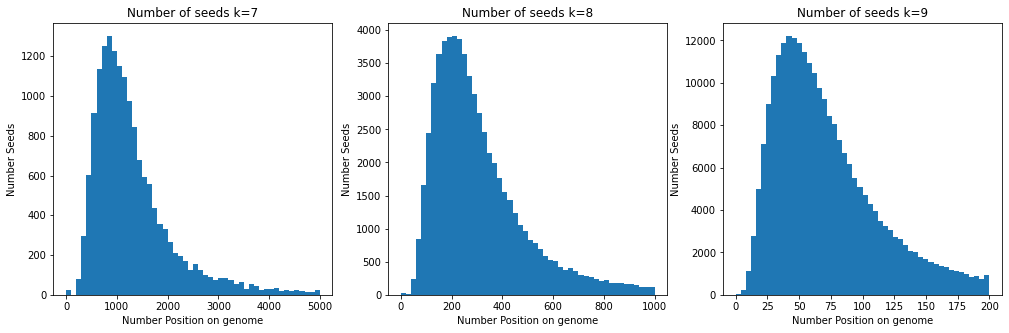

In [24]:
xmax = [5000,1000,200]
fig, axs = plt.subplots(1,3, figsize=(17,5))
for i, (k, array) in enumerate(dNumbSeeds.items()):
    axs[i].hist(array,50,(0,xmax[i]))
    axs[i].set_title(f"Number of seeds k={k}")
    axs[i].set_xlabel("Number Position on genome")
    axs[i].set_ylabel("Number Seeds")
fig.savefig("NumberPositions.png")

In [437]:
len(wholeGenome)

23513712